# EE/CS 228 HW#1 - Linear MNIST Classifier


Submitted by : Vishnu Shukla

Date Started : 10-16-2024

In [148]:
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Question 1 : Write the code for downloading and formatting the data

Using **Py-Torch's** inbuilt function **dataset.MNIST** to download the data 

In [149]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data',
                                       train=True, 
                                       download=True, 
                                       transform=transform)

testset = torchvision.datasets.MNIST(root='./data', 
                                     train=False, 
                                     download=True, 
                                     transform=transform)


Preview of the MNIST dataset with their Labels

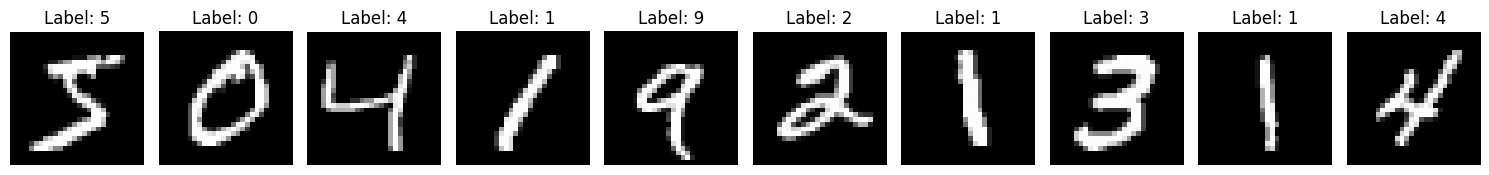

In [150]:

num_images = 10
images, labels = [], []
for i in range(num_images):
    img, label = trainset[i]
    images.append(img.squeeze().numpy())
    labels.append(label)

fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
for i in range(num_images):
    axes[i].imshow(images[i], cmap='gray')
    axes[i].set_title(f'Label: {labels[i]}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()


**We can flatten or squeeze an image of size 28x28 into a single 1D tensor with 784 elements (28 * 28 = 784)**

In [151]:
# Prepare the data
x_train = torch.stack([img.squeeze().view(-1) for img, _ in trainset])
y_train = torch.tensor([label for _, label in trainset])
x_test = torch.stack([img.squeeze().view(-1) for img, _ in testset])
y_test = torch.tensor([label for _, label in testset])


**Step 2** 
Now Each label y represents a categorical value that corresponds to a digit from 0 to 9. Since machine learning models operate on numerical data, we need to convert these categorical labels into a numerical format. We will use Onone-hot encoding, which transforms each label y into a vector $y^{oh}$ of size 10

In [152]:
def one_hot_encode(labels):
    unique_classes = torch.unique(labels, sorted=True)
    num_classes = unique_classes.shape[0]
    onehot_encoded = torch.zeros((labels.shape[0], num_classes))
    onehot_encoded[torch.arange(labels.shape[0]), labels.long()] = 1
    return onehot_encoded

In [153]:
y_train_onehot = one_hot_encode(y_train)
y_test_onehot = one_hot_encode(y_test)

print(f"Training set shape: {x_train.shape}")
print(f"Testing set shape: {x_test.shape}")
print(f"One-hot encoded training labels shape: {y_train_onehot.shape}")
print(f"One-hot encoded testing labels shape: {y_test_onehot.shape}")

Training set shape: torch.Size([60000, 784])
Testing set shape: torch.Size([10000, 784])
One-hot encoded training labels shape: torch.Size([60000, 10])
One-hot encoded testing labels shape: torch.Size([10000, 10])


## **Question 2**: (5 pts)  Write the code for minibatch SGD implementation for your linear MNIST classifier.

**To implement the algorithm, we'll start by creating separate functions for each step.**

1 - First, the **Initialize Parameters** function will set up the random weights for the classifier. It will look for appropriate param for the functions

2 - Next, I defined the **Forward function**, which calculate the predictions by performing matrix multiplication of the input data with the weights and bias I used famous **square loss** to measure the difference between the predicted values and the actual labels. This will help the model gauge its accuracy and adjust accordingly. Then, the **Backward Pass** function will compute the gradient of the loss with respect to the weights and biases, enabling the model to learn from the errors and make nesscary corrections

3- The **Main Driver Function**, **SGD**, will split the dataset into smaller batches. It will update the weights and biases after processing each mini-batch, ensuring efficient training. This modular approach allows for easier debugging, optimization, and understanding of each step in the model training process.

4 - And Lastly we will Visulize the output for better understanding for the results and conclude the performance of the built model

**Setting Up Parameters** : I have conditioned the model on Famous Learning parameters , can change after seeing the performance of model

In [154]:
def log_every_5_epochs(epoch, train_acc, test_acc, loss):
    if (epoch + 1) % 5 == 0:
        print(f"After {epoch + 1} epochs:")
        print(f"Training Accuracy: {train_acc:.4f}")
        print(f"Testing Accuracy: {test_acc:.4f}")
        print(f"Loss: {loss:.4f}")
        print("--------------------")

In [155]:
# Define the classifier function with logging
import torch.nn.functional as F

def run_classifier_with_logging(x_training, true_y_training, onehot_y_training, x_testing, true_y_testing, onehot_y_testing, lr, n_epochs, n_iters, batch_size):
    w = torch.zeros((onehot_y_training.shape[1], x_training.shape[1]), requires_grad=True)
    b = torch.zeros((1, onehot_y_training.shape[1]), requires_grad=True)

    array_of_losses = []
    array_of_train_acc = []
    array_of_test_acc = []

    for epoch in range(n_epochs):
        epoch_losses = []
        
        
        for iter in range(n_iters):
            random_indices = torch.randint(0, x_training.size(0), (batch_size,))
            x_batch = x_training[random_indices]
            y_batch = onehot_y_training[random_indices]
            logits = torch.matmul(x_batch, w.t()) + b
            loss = F.cross_entropy(logits, y_batch.float())
            epoch_losses.append(loss.item())
            loss.backward()
            with torch.no_grad():
                w -= lr * w.grad
                b -= lr * b.grad
                w.grad.zero_()
                b.grad.zero_()

        avg_loss = sum(epoch_losses) / len(epoch_losses)
        array_of_losses.append(avg_loss)

        # Calculate accuracy
        with torch.no_grad():
            train_logits = torch.matmul(x_training, w.t()) + b
            train_preds = torch.argmax(train_logits, dim=1)
            train_acc = (train_preds == true_y_training).float().mean().item()
            array_of_train_acc.append(train_acc)

            test_logits = torch.matmul(x_testing, w.t()) + b
            test_preds = torch.argmax(test_logits, dim=1)
            test_acc = (test_preds == true_y_testing).float().mean().item()
            array_of_test_acc.append(test_acc)

        # Log every 5 epochs
        log_every_5_epochs(epoch, train_acc, test_acc, avg_loss)

    return array_of_train_acc, array_of_test_acc, array_of_losses, w, b


def log_every_5_epochs(epoch, train_acc, test_acc, loss):
    if (epoch + 1) % 5 == 0:
        print("--------------------")
        print("After " + str(epoch + 1) + " epochs:")
        print("Training Accuracy: " + str(train_acc) + "")
        print("Testing Accuracy: " + str(test_acc) + "")
        print("Loss: " + str(loss) + "")
        print("--------------------")

Classifier function and logging function defined successfully.


Defining Learning Parameters

In [156]:
lr = 0.01
n_epochs = 30 
n_iters = 100
batch_size = 100

# Plot for some of the most important features for analysis

Training Loss over Epochs on MNIST Dataset

Confusion matrix between True label and Predicted label

Traning vs Testing over the Epoch on MNIST Dataset

Sample Predection on MNIST Dataset


After 5 epochs:
Training Accuracy: 0.8751999735832214
Testing Accuracy: 0.8830999732017517
Loss: 0.4968131610751152
--------------------
After 10 epochs:
Training Accuracy: 0.8907666802406311
Testing Accuracy: 0.897599995136261
Loss: 0.4186176839470863
--------------------
After 15 epochs:
Training Accuracy: 0.897933304309845
Testing Accuracy: 0.9035999774932861
Loss: 0.37721819162368775
--------------------
After 20 epochs:
Training Accuracy: 0.9003166556358337
Testing Accuracy: 0.9067000150680542
Loss: 0.3584924238920212
--------------------
After 25 epochs:
Training Accuracy: 0.9035666584968567
Testing Accuracy: 0.9090999960899353
Loss: 0.3469783554971218
--------------------
After 30 epochs:
Training Accuracy: 0.9057499766349792
Testing Accuracy: 0.9107999801635742
Loss: 0.34983983665704727
--------------------
Training completed.


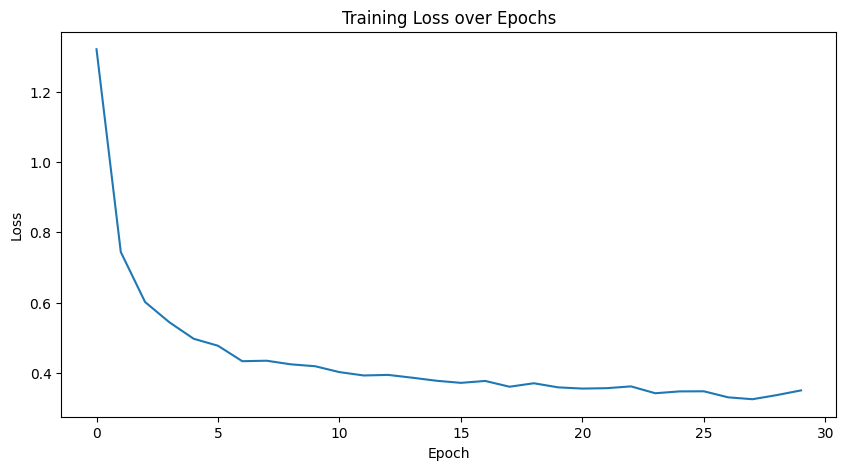

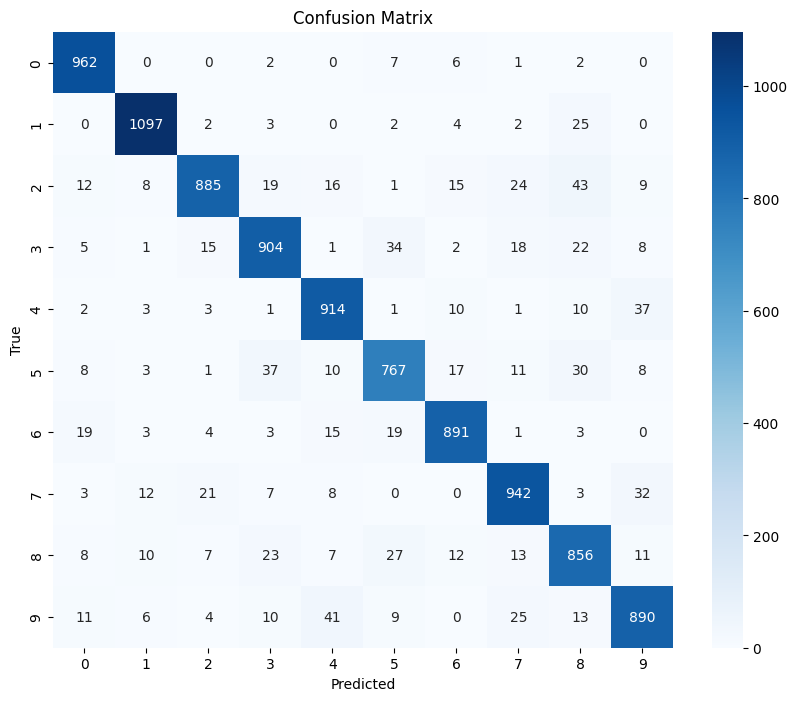

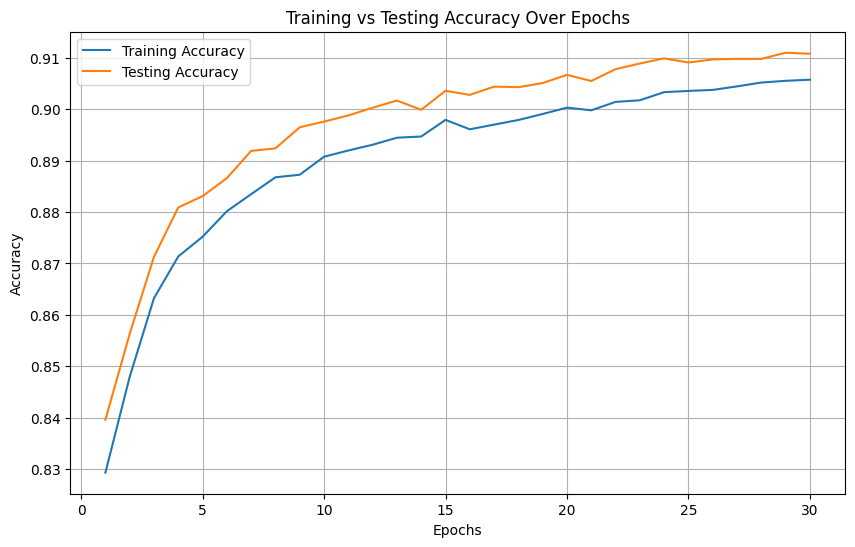

Training vs Testing Accuracy plot created and displayed.


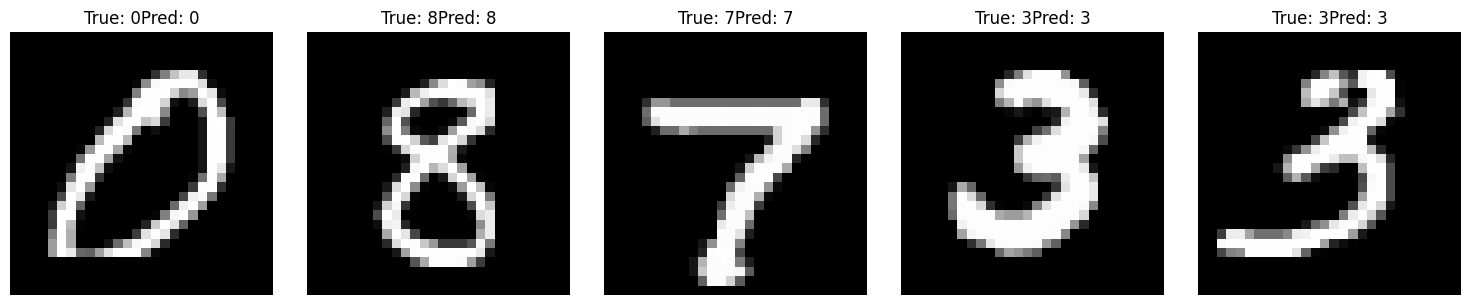

In [157]:
#Running the Model
train_acc, test_acc, losses, w, b = run_classifier_with_logging(x_train, y_train, y_train_onehot, x_test, y_test, y_test_onehot, lr, n_epochs, n_iters, batch_size)

print("Training completed.")

plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

with torch.no_grad():
    test_logits = torch.matmul(x_test, w.t()) + b
    test_preds = torch.argmax(test_logits, dim=1)

cm = confusion_matrix(y_test, test_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(test_acc) + 1), test_acc, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


def plot_sample_predictions(x_test, y_test, test_preds, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        idx = np.random.randint(0, len(x_test))
        img = x_test[idx].reshape(28, 28).numpy()
        true_label = y_test[idx].item()
        pred_label = test_preds[idx].item()
        
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'True: {true_label}\
Pred: {pred_label}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_sample_predictions(x_test, y_test, test_preds)

# **Question 3**: (7 pts) 
**The role of batch size:** Run your code with batch sizes B = [1, 10, 100, 1000]. For each batch size,

*   Determine a good choice of Learning Rate
*   Pick ITR sufficiently large to ensure the (approximate) convergence of the training loss
*   Plot Progress of Training loss (y-axis) as a function of the iteration counter t (x-axis)
*   Report how long does the training takes
*   Plot Progress of the test accuracy (y-axis) as a function of the iteration counter t (x-axis)



In [158]:
import time
batch_sizes = [1,10,100,1000,60000]
results = {}
computation_times = {}

for batch_size in batch_sizes:
    print("Running classifier with batch size: " + str(batch_size))
    start_time=time.time()
    train_acc, test_acc, losses, w, b = run_classifier_with_logging(x_train, y_train, y_train_onehot, x_test, y_test, y_test_onehot, lr, n_epochs, n_iters, batch_size=batch_size
    )
    results[batch_size] = {
        'train_acc': train_acc,
        'test_acc': test_acc,
        'losses': losses
    }
    end_time = time.time()
    computation_time = end_time - start_time

    results[batch_size] = {
    'train_acc': train_acc,
    'test_acc': test_acc,
    'losses': losses
}
    computation_times[batch_size] = computation_time

print("Completed running classifier with different batch sizes.")
print("Computation times:", computation_times)

Running classifier with batch size: 1
After 5 epochs:
Training Accuracy: 0.7509166598320007
Testing Accuracy: 0.7630000114440918
Loss: 1.1081048663615
--------------------
After 10 epochs:
Training Accuracy: 0.7861166596412659
Testing Accuracy: 0.7932999730110168
Loss: 0.6408703776416769
--------------------
After 15 epochs:
Training Accuracy: 0.8172833323478699
Testing Accuracy: 0.8335999846458435
Loss: 0.959848998712838
--------------------
After 20 epochs:
Training Accuracy: 0.7284666895866394
Testing Accuracy: 0.7354999780654907
Loss: 1.110400976387159
--------------------
After 25 epochs:
Training Accuracy: 0.8375833630561829
Testing Accuracy: 0.847599983215332
Loss: 0.6210288803331846
--------------------
After 30 epochs:
Training Accuracy: 0.8383333086967468
Testing Accuracy: 0.8436999917030334
Loss: 1.5699283627284921
--------------------
Running classifier with batch size: 10
After 5 epochs:
Training Accuracy: 0.8572166562080383
Testing Accuracy: 0.8651000261306763
Loss: 0.494

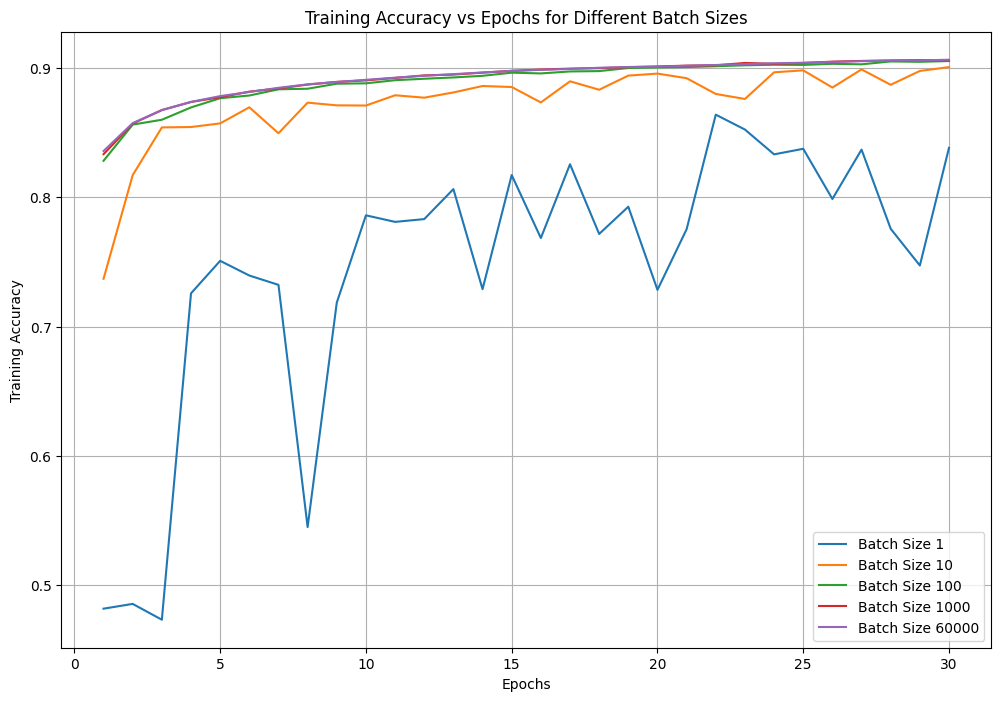

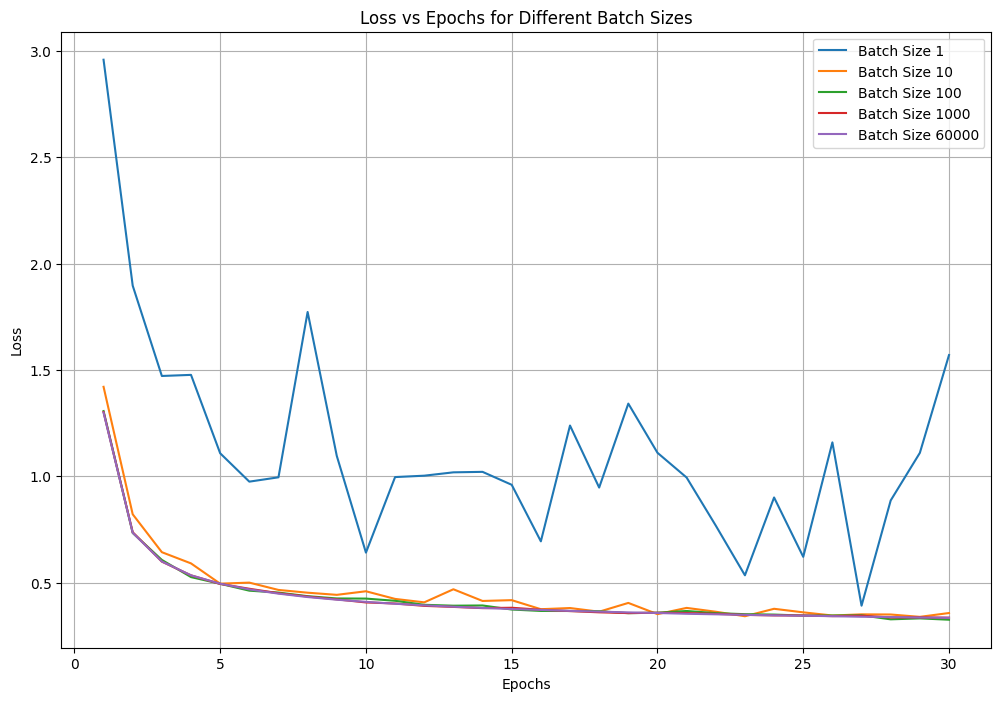

Comparison Table:
            Final Training Accuracy  Final Testing Accuracy  Final Loss  Computation Time (s)
Batch Size                                                                                   
1                          0.838333                  0.8437    1.569928              1.026177
10                         0.900767                  0.9049    0.356800              2.467446
100                        0.905483                  0.9113    0.325309              4.540550
1000                       0.905867                  0.9118    0.334979             10.004751
60000                      0.906483                  0.9113    0.334334            245.726923


In [159]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for batch_size in batch_sizes:
    plt.plot(range(1, n_epochs + 1), results[batch_size]['train_acc'], label=f'Batch Size {batch_size}')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs Epochs for Different Batch Sizes')
plt.legend()
plt.grid(True)
plt.savefig('training_accuracy_vs_epochs.png')
plt.show()


plt.figure(figsize=(12, 8))
for batch_size in batch_sizes:
    plt.plot(range(1, n_epochs + 1), results[batch_size]['losses'], label=f'Batch Size {batch_size}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs for Different Batch Sizes')
plt.legend()
plt.grid(True)
plt.savefig('loss_vs_epochs.png')
plt.show()


data = []
for batch_size in batch_sizes:
    data.append({
        'Batch Size': batch_size,
        'Final Training Accuracy': results[batch_size]['train_acc'][-1],
        'Final Testing Accuracy': results[batch_size]['test_acc'][-1],
        'Final Loss': results[batch_size]['losses'][-1],
        'Computation Time (s)': computation_times[batch_size]
    })

comparison_table = pd.DataFrame(data)
comparison_table = comparison_table.set_index('Batch Size')
print("\
Comparison Table:")
print(comparison_table.to_string())
comparison_table.to_csv('batch_size_comparison.csv')

# **Question 4** : : (1 pts) 
Comment on the role of batch size.

From the analysis, larger batch sizes generally improve training and testing accuracy while reducing loss due to more stable gradient estimates. However, the improvements are marginal, indicating that smaller batch sizes can still perform competitively with enough epochs. While larger batch sizes may offer better optimization, they also demand more computational resources, making smaller batch sizes a viable choice when efficiency is a concern.

# **Question 5**: : (6 pts) 
**The role of training dataset size:** Let us reduce the training dataset size. Instead of N = 60, 000, let us pick a subset S′ of size N′ from the original dataset without replacement and uniformly at random. Fix batch size to B = 100. Repeat the steps above for N′ ∈ {100, 500, 1000, 10000}. Comment on the accuracy as a function of dataset size.

In [160]:
np.random.seed(42)
torch.manual_seed(42)

subset_sizes = [100, 500, 1000, 10000]
results = {}

def select_random_subset(x, y, size):
    indices = np.random.choice(x.shape[0], size, replace=False)
    return x[indices], y[indices]

for size in subset_sizes:
    print(f"Running classifier for subset size: {size}")
    x_train_subset, y_train_subset = select_random_subset(x_train, y_train, size)
    train_acc, test_acc, losses, w, b = run_classifier_with_logging(x_train, y_train, y_train_onehot, x_test, y_test, y_test_onehot, lr, n_epochs, n_iters, 100
    )
    results[size] = {
        'train_acc': train_acc,
        'test_acc': test_acc,
        'losses': losses
    }

Running classifier for subset size: 100
After 5 epochs:
Training Accuracy: 0.8756999969482422
Testing Accuracy: 0.8828999996185303
Loss: 0.47930384129285813
--------------------
After 10 epochs:
Training Accuracy: 0.8885499835014343
Testing Accuracy: 0.8949000239372253
Loss: 0.41314215168356894
--------------------
After 15 epochs:
Training Accuracy: 0.8956666588783264
Testing Accuracy: 0.9028000235557556
Loss: 0.37951320856809617
--------------------
After 20 epochs:
Training Accuracy: 0.900433361530304
Testing Accuracy: 0.9065999984741211
Loss: 0.35523616209626196
--------------------
After 25 epochs:
Training Accuracy: 0.9041500091552734
Testing Accuracy: 0.909500002861023
Loss: 0.3463792829215527
--------------------
After 30 epochs:
Training Accuracy: 0.9041666388511658
Testing Accuracy: 0.9093999862670898
Loss: 0.34115588925778867
--------------------
Running classifier for subset size: 500
After 5 epochs:
Training Accuracy: 0.8743333220481873
Testing Accuracy: 0.8827999830245972

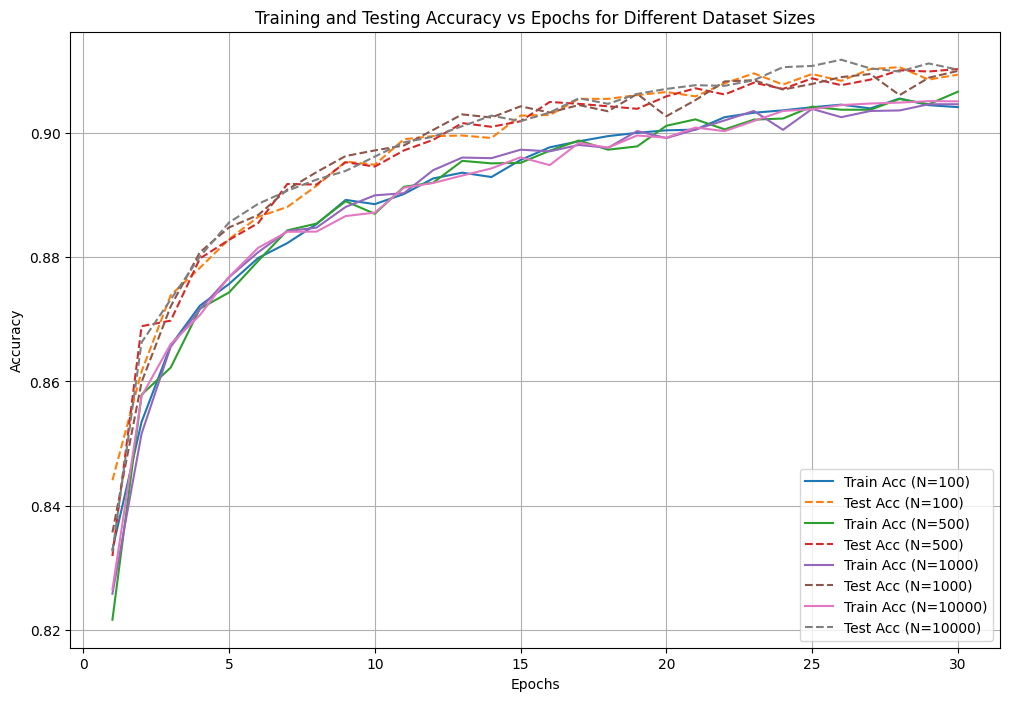

In [161]:
plt.figure(figsize=(12, 8))
for size in subset_sizes:
    plt.plot(range(1, len(results[size]['train_acc']) + 1), results[size]['train_acc'], label=f'Train Acc (N={size})')
    plt.plot(range(1, len(results[size]['test_acc']) + 1), results[size]['test_acc'], label=f'Test Acc (N={size})', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy vs Epochs for Different Dataset Sizes')
plt.legend()
plt.grid(True)
plt.show()

Training dataset size is key to model performance—larger datasets improve accuracy, stability, generalization, and reduce overfitting. However, gains diminish with very large datasets, so it's important to balance performance improvements with computational constraints.
Based on the plot, we can observe:

Larger dataset sizes (N=10000) consistently achieve higher accuracy for both training and testing.
Smaller dataset sizes (N=100, 500) show lower accuracy and more fluctuations.
As dataset size increases, the gap between training and testing accuracy narrows.
The model's ability to generalize improves with larger dataset sizes.

# **Question 6**
**Simpler Life**: Run the linear MNIST classifier with batchsize B = 100 over the full dataset by using PyTorch or Tensorflow. Use same learning rate and initialization W0 = 0. Verify that it is consistent with your handcoded algorithm by comparing your results (the accuracy and training loss plots).

In [162]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


batch_size = 100
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

class LinearClassifier(nn.Module):
    def __init__(self):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(28 * 28, 10, bias=True)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.linear(x)

model = LinearClassifier()

In [163]:

# Initialize weights to 0
model.linear.weight.data.fill_(0)
model.linear.bias.data.fill_(0)
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), learning_rate)


In [164]:

n_epochs = 30
train_losses = []
train_accuracies = []
test_accuracies = []
from tqdm import tqdm
for epoch in tqdm(range(n_epochs), desc="Epochs"):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
    
    train_loss = epoch_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
  
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_accuracy = correct / total
    test_accuracies.append(test_accuracy)

Epochs: 100%|██████████| 30/30 [06:42<00:00, 13.41s/it]


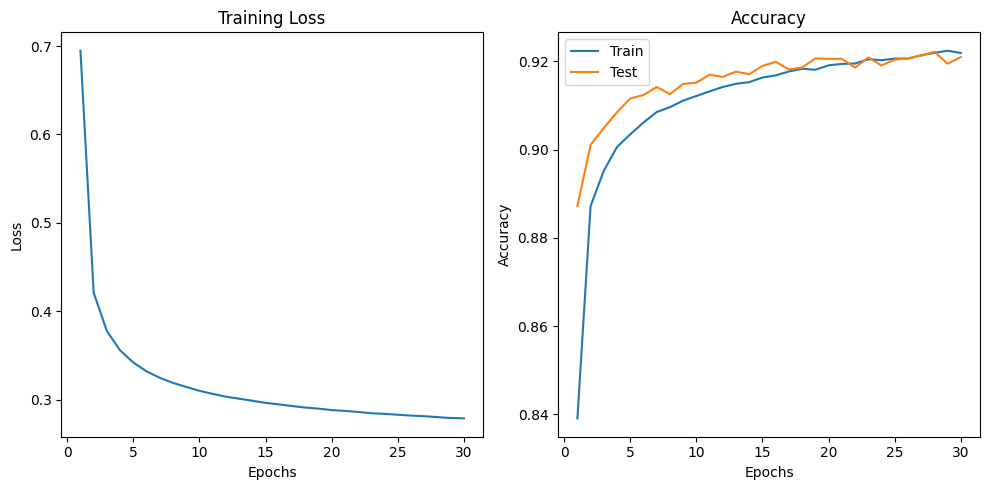

Final training accuracy: 0.9219
Final test accuracy: 0.9210


In [165]:

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_losses)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), train_accuracies, label='Train')
plt.plot(range(1, n_epochs + 1), test_accuracies, label='Test')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('pytorch_mnist_results.png')
plt.show()
plt.close()
print(f"Final training accuracy: {train_accuracies[-1]:.4f}")
print(f"Final test accuracy: {test_accuracies[-1]:.4f}")

## Personal Model vs Py-torch Comparision

In [166]:
my_train_acc = results[10000]['train_acc'][-1]
my_test_acc = results[10000]['test_acc'][-1]
print("My Model Training Accuracy:", my_train_acc)
print("My Model Test Accuracy:", my_test_acc)




pytorch_final_train_acc = train_accuracies[-1]
pytorch_final_test_acc = test_accuracies[-1]
print("PyTorch Model Training Accuracy:", pytorch_final_train_acc)
print("PyTorch Model Test Accuracy:", pytorch_final_test_acc)

My Model Training Accuracy: 0.9050999879837036
My Model Test Accuracy: 0.9101999998092651
PyTorch Model Training Accuracy: 0.9219166666666667
PyTorch Model Test Accuracy: 0.921


# Analysis : 

Both the Personal and PyTorch models show that the PyTorch model achieves slightly higher accuracy, suggesting better optimization or convergence. The personal model shows a steady decrease in training loss over the epochs, indicating consistent learning. However, the convergence rate appears slower compared to the PyTorch model. The PyTorch model demonstrates a more rapid decrease in training loss, suggesting faster convergence. This could be due to more efficient optimization techniques or better handling of gradient updates.

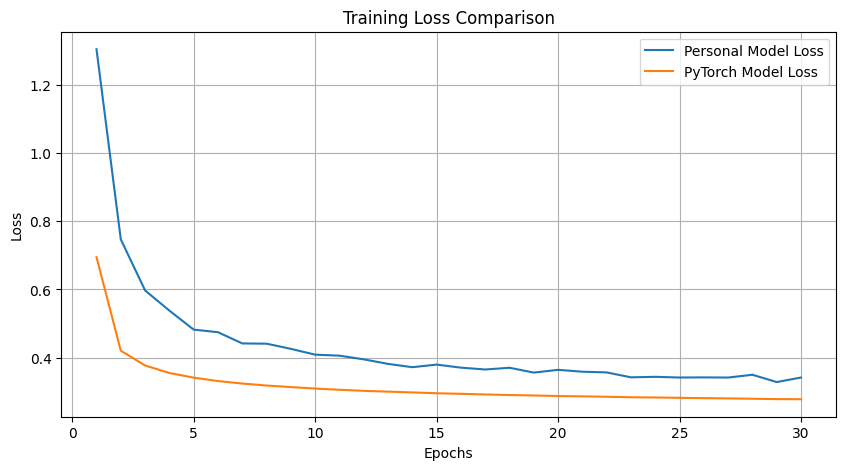

In [167]:

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(results[10000]['losses']) + 1), results[10000]['losses'], label='Personal Model Loss')
plt.plot(range(1, n_epochs + 1), train_losses, label='PyTorch Model Loss')

plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

# Assigment Completed

Referances 

[1]: Stackoverflow
[2]: Py-Torch Mastery
[3]: Builtin.com
[4]: Zero to Hero - Karapathy